# Text Classification Exam

Welcome to the Text Classification Practical Exam. In this exam, you will be tasked with building, training, and evaluating an NLP model to classify text data. You are provided with a labeled dataset containing both the text and its corresponding class labels.

Your objective is to develop a model that accurately predicts the class of the given text. Make sure to follow best practices in data preprocessing, model selection, and evaluation to achieve optimal results.

Good luck!
___

# Install and Import Needed Libraries

You can use `pyarabic` or any other library to pre-process and clean the Arabic text.

In [4]:
!pip install pyarabic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 6.1 MB/s eta 0:00:00


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from pyarabic import araby
from nltk.corpus import stopwords
import nltk
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pyarabic.number as number
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense


# Download the Dataset

Please note that you are allowed to take a subset of this dataset, the reason for that is it might take a long time to train the model on.

In [1]:
!kaggle datasets download -d khaledzsa/sanad
!unzip sanad.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/sanad
License(s): unknown
 94% 67.0M/71.4M [00:02<00:00, 39.2MB/s]
100% 71.4M/71.4M [00:02<00:00, 27.9MB/s]
Archive:  sanad.zip
  inflating: sanad.csv               


# Data Exploration

Before diving into preprocessing and model building, it’s important to first explore the dataset to understand its structure, distribution, and key characteristics. This step will help you gain insights into the data and guide your decisions in subsequent steps. Here’s what to consider:

1. **Inspect the Data**:
   Start by looking at the first few rows of the dataset to get a sense of its structure. Check the columns, data types, and a few sample entries. This helps to ensure that the data is loaded correctly and gives you an initial overview of the content.

2. **Check for Missing Values**:
   Identify if there are any missing values in the dataset.

3. **Distribution of Labels**:
   Examine the distribution of the target labels (classes).

4. **Text Data Characteristics (Bonus)**:
   Analyze the length of the text data. It is useful to calculate the number of words or characters in each text sample to understand how long the texts are. This will help you set a suitable `max_length` for tokenization and padding later. You can plot a histogram of text lengths to visualize the distribution.

5. **Common Words and Vocabulary (Bonus)**:
   Explore the most frequent words in the text data.

### Load the dataset

In [6]:
week_7_project_df = pd.read_csv('/content/sanad.csv')

In [7]:
week_7_project_df.head()

,text,label
0,https://example.com/resource/الشاٌرقة -ْ محمِد...,Culture
1,https://example.com/resource/اَنِطٌلقّتَ ٍفٍيّ...,Culture
2,https://example.com/resource/أُقيًمٌتِ مِساءُ ...,Culture
3,https://example.com/resource/بٍاسُمةَ يًوٌنٍس ...,Culture
4,https://example.com/resource/قُرر اَتحِاد اًلْ...,Culture


In [8]:
week_7_project_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39885 entries, 0 to 39884
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    39885 non-null  object
 1   label   39885 non-null  object
dtypes: object(2)
memory usage: 623.3+ KB


In [9]:
week_7_project_df.describe()

,text,label
count,39885,39885
unique,39885,7
top,https://example.com/resource/تنطًلقٍ اٌليومّ َ...,Politics
freq,1,6334


In [10]:
week_7_project_df.isnull().sum()

# 0 null => it's good =)

,0
text,0
label,0


In [11]:
week_7_project_df['label'].value_counts()

,count
label,
Politics,6334
Medical,6292
Culture,6098
Finance,6095
Tech,5979
Sports,5859
Religion,3228


## text data characteristics => bonus    =)

In [12]:
week_7_project_df['text_length'] = week_7_project_df['text'].apply(lambda x: len(x.split()))
week_7_project_df['text_length'].describe()

,text_length
count,39885.000000
mean,267.092942
std,168.397669
min,20.000000
25%,131.000000
50%,224.000000
75%,377.000000
max,700.000000


<Axes: >

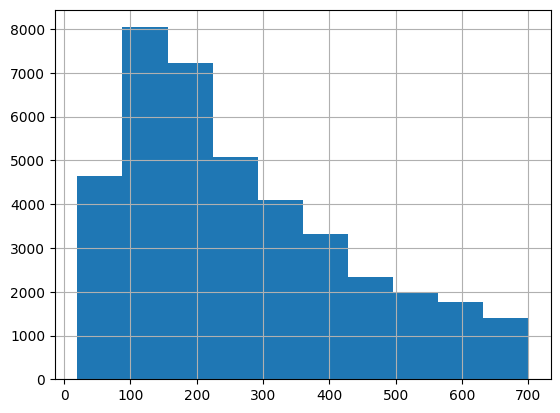

In [13]:
week_7_project_df['text_length'].hist()

### common words and vocabulary ==> bonus  =)

In [14]:
from collections import Counter
all_words = []
for text in week_7_project_df['text']:
  words = text.split()
  all_words.extend(words)
word_counts = Counter(all_words)

In [15]:
week_7_project_df['text'][0]

'https://example.com/resource/الشاٌرقة -ْ محمِد وِلدٌ َمحمْدُ ٌسّاٍلمَعرٍضت مًسُاءٍ أًمسَ اَلأَول علَىِ ٍخْشبٌةّ مسرح قصَر ّالثْقًافةً ٌفي اِلشاْرقُة ٍاًلمسرِحية ٍاٍلسْعٍودْيَة ً"ْبَعيُدْاًّ عن اٌلسيطرة"ّ ًلِفرقةَ مَسّرُحَ ًاِلطِاٌئف،ّ ْمن ّتٌأٌليُف فُهًدِ ّرّدِةَ الحاّرثي، ّوٌإُخراًج َسٍاٌمَي ًصّاَلٍحٍ الزَهرانيّ،ْ ٌوُذّلكّ فٌيً َرٌابعٍةٌ ٌليالي ِالدورْةَ اَلأوٌلى ٌمن مًهرًجِانٌ اْلشْارِقُة لّلّمَسُرٌحْ الخليجي ٌ.تًبًدَأْ اْلْمسرٍحيٍة بثًلاٍثّة َأشخاٍصٍ ٍيجٍلْسِونَ ُفي قاعةِ مّكتبةِ،ٌ ًيِنهمُك كٌل َمْنهٌمٌ ّفي ُالقرِاءة بْشغَف،ِ ُثُم يبِدأِوْن ًفيَ الٍحوٌاُر لنٍكُتشُفُ ُأِنهمّ كاْنوّاٌ ْيِقُرَأّونْ ِروٍاياّت لُأستُاّذهم ًالكِاتِب اّلمٌبدَعَ ُالٍذيٍ مِاْت ُوْتِرْك ُرِوايٌاتَ فريَدَةً،ٍ ُرٌسم فْيهًا ِشْخُصًياُت ٍغاية فُي الُدُقٌة، ٌويتحدٌثونّ ْعنُ ضرورة تكِرٍيمَ ِأستْاّذُهًم،ٌ ويٍتِفِقون ُعُلْىّ طرٍيقّة ًخاصةّ َلًلتكرّيم وُهيٌ ِإُخرٍاّج ُشِخصِيٌاتَه ًمنُ ْرِواياٍتها ٍلٍتَعٍيٍش في ّاٍلوْاقًع، وِيًنتِقّونً شِخُصيًاتٌ مركزيُة، ٍأْولها ْاُلحِلاق ٍاٍلذي ٍكٍان ًطَيًبًاًُ،ٌ حْافٍظاً لأُسرّاٌر 

In [16]:
week_7_project_df['text']

,text
0,https://example.com/resource/الشاٌرقة -ْ محمِد...
1,https://example.com/resource/اَنِطٌلقّتَ ٍفٍيّ...
2,https://example.com/resource/أُقيًمٌتِ مِساءُ ...
3,https://example.com/resource/بٍاسُمةَ يًوٌنٍس ...
4,https://example.com/resource/قُرر اَتحِاد اًلْ...
...,...
39880,https://example.com/resource/أعلّنت شّركٌةً بّ...
39881,https://example.com/resource/بُتٍاَرٌيًخَ 28ْ ...
39882,https://example.com/resource/دبَيُ:َ «ُاَلخليج...
39883,https://example.com/resource/LٌG GًS2ْ9ً0 Coْo...


# Data Cleaning and Preprocessing

In this section, we will focus on cleaning and filtering the dataset, preparing it for the text classification task. We will implement the following steps:

1. **Remove missing values**:
   First, we eliminate any rows with missing values to ensure the dataset is complete and consistent.

2. **Filter by text length (Bonus)**:
   To maintain a uniform dataset, we will filter the text samples by a specified word count range. This ensures that the texts are neither too short to lack context nor too long to introduce unnecessary complexity.

3. **Arabic stopwords loading**:
   We load a list of Arabic stopwords to filter out commonly used but contextually insignificant words. This is an important step for improving the performance of the model, as stopwords do not contribute valuable information.

4. **Text cleaning**:
   We apply a series of text cleaning steps to standardize and simplify the text data. This involves:
   - **Removing links (URLs)**: Any URLs present in the text are removed as they are not meaningful for classification purposes.
   - **Removing special characters and punctuation**: This step removes any non-alphabetical characters, ensuring the text only contains meaningful words.
   - **Removing Arabic diacritics (Tashkeel) and elongated letters (Tatweel)**: Diacritical marks and elongated letters are stripped out to standardize the text.
   - **Removing Arabic stopwords**: Words that are part of the stopwords list are removed, as they do not add value to the classification task.
   - **Stemming or Lemmmatization**: Either stemming or lemmatization is applied to reduce words to their root or base form.
   - **Normalizing Hamza**: Any variation of the Hamza character is normalized for consistency.

   **Note:** Most of these you can do using the library [PyArabic](https://pyarabic.readthedocs.io/ar/latest/README.html#features)

5. **Final cleanup**:
   Apply the cleanup function to the feature column.

By following these steps, the text will be cleaned, filtered, and ready for tokenization!

In [18]:
# chake missing value :
week_7_project_df.isnull().sum()
# i dont have a missing value & so no need step num 1

,0
text,0
label,0
text_length,0


In [19]:
# Filter by text length

week_7_project_df = week_7_project_df[
    (week_7_project_df['text_length'] >= 4) &
    (week_7_project_df['text_length'] <= 100)
]


In [20]:
week_7_project_df['text_length'].describe()

,text_length
count,6198.000000
mean,70.004034
std,20.412271
min,20.000000
25%,55.000000
50%,72.000000
75%,88.000000
max,100.000000


In [39]:
nltk.download('stopwords')
arabic_stopwords = stopwords.words('arabic')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


####I tried to solve it with several libraries, the first of which was pyarabic
####But an error occurred and it took a long time to solve the error So I used the re library.And the links were removed from the texts and the texts were cleaned and formatted

In [46]:
def clean_the_text_week7 (text):

  text = re.sub(r'http\S+|www\.\S+', '', text)
  text = re.sub(r"[^\w\s]", "", text)
  text = araby.strip_diacritics(text)
  text = araby.strip_tatweel(text)
  text = araby.normalize_hamza(text)
  return text
week_7_project_df['text'] = week_7_project_df['text'].apply(clean_the_text_week7)


In [47]:
week_7_project_df['text']

,text
4,اتحاد الءدباء والكتاب الموريتانيين عقد مءتمره...
7,ءمس الءديب الءسباني ميجيل ديليبس الذي يعتبر و...
38,حبيب يوسف الصايغ مدير عام المركز الثقافي الءع...
56,فعاليات البرنامج الثقافي لداءرة الثقافة والءع...
61,الخليج ينظم اتحاد كتاب وءدباء الءمارات في ءبو...
...,...
39801,شركة ميتسومي الموزع الراءد والمعتمد ل 20 علام...
39814,سمو الشيخ منصور بن محمد بن راشد ءءل مكتوم معر...
39838,الخليج اختتمت شرطة عجمان فعالياتها في معرض جي...
39857,مينا تليكوم البحرين عن طرح جهاز واي ماكس جديد...


In [48]:
week_7_project_df

,text,label,text_length
4,اتحاد الءدباء والكتاب الموريتانيين عقد مءتمره...,Culture,59
7,ءمس الءديب الءسباني ميجيل ديليبس الذي يعتبر و...,Culture,96
38,حبيب يوسف الصايغ مدير عام المركز الثقافي الءع...,Culture,94
56,فعاليات البرنامج الثقافي لداءرة الثقافة والءع...,Culture,55
61,الخليج ينظم اتحاد كتاب وءدباء الءمارات في ءبو...,Culture,65
...,...,...,...
39801,شركة ميتسومي الموزع الراءد والمعتمد ل 20 علام...,Tech,64
39814,سمو الشيخ منصور بن محمد بن راشد ءءل مكتوم معر...,Tech,93
39838,الخليج اختتمت شرطة عجمان فعالياتها في معرض جي...,Tech,88
39857,مينا تليكوم البحرين عن طرح جهاز واي ماكس جديد...,Tech,82


# Tokenization, Padding, and Data Splitting

In this step, we will prepare the text data for input into a model by converting the text into numerical sequences, padding them to a uniform length, and splitting the dataset into training and testing sets. Here's an overview of the steps involved:

1. **Tokenization**:
   We use a tokenizer to convert the cleaned text into numerical sequences. You can use `Tokenizer` tokenizer from `tensorflow.keras.preprocessing.text` package or any other tokenizer you like.

2. **Text to sequences**:
   After fitting the tokenizer on the cleaned text, we transform each text into a sequence of numbers, where each number corresponds to a token (word) in the text.

3. **Padding the sequences**:
   Since different texts may vary in length, we pad the sequences to ensure they all have the same length.

4. **Label encoding**:
   The labels (target values) also need to be converted into numerical form if they are not encoded.

5. **Train-test split**:
   The dataset is divided into training and testing sets. We allocate 80% of the data for training the model and reserve 20% for testing its performance.
   
   - The **training data** consists of the padded sequences used to train the model.
   - The **training labels** are the encoded labels corresponding to the training data.
   - The **testing data** is used to assess the model’s performance after training.
   - The **testing labels** are the encoded labels corresponding to the testing data.

6. **Data shape confirmation**:
   After splitting the data, we print the shape (dimensions) of both the training and testing sets to confirm that the data is properly divided and formatted.

By the end of this step, the text data will be transformed into padded numerical sequences, the labels will be encoded, and the data will be split into training and testing sets for model development and evaluation.

In [61]:
#tokenization
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(week_7_project_df['text'])
word_index = tokenizer.word_index

In [62]:
#sequences & padding
sequences = tokenizer.texts_to_sequences(week_7_project_df['text'])
padded_sequences = pad_sequences(sequences, padding='post', maxlen=100)


In [63]:
# split the dataset
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, week_7_project_df['label'], test_size=0.2, random_state=42
)

### shape the dataset =)

In [64]:
X_train.shape

(4958, 100)

In [65]:
X_test.shape

(1240, 100)

In [66]:
y_train.shape

(4958,)

In [67]:
y_test.shape

(1240,)

# Building the Classifier

In this step, you will design and build a NLP Classifier model to classify text data. Below is a breakdown of the key components you'll implement, but it's up to you to decide how to configure them based on your understanding and experimentation:

1. **Model Type**:
   You will use a Sequential model, which allows you to stack layers in a linear sequence.

2. **Input Layer**:
   Define the shape of the input data. Consider the dimensions of your padded sequences and set the input shape accordingly.

3. **Embedding Layer**:
   The embedding layer will convert input tokens (integers) into dense vector representations. You will need to determine the size of the input dimension (based on your vocabulary) and the output dimension (embedding size).

4. **Bidirectional Simple RNN/LSTM Layers**:
   You can add one or more recurrent layers. Consider using Bidirectional layers to capture contextual information from both directions (forward and backward). You can chose SimpleRNN/GRU/LSTM to perform this step.

5. **Dense Layers**:
   Add one or more fully connected (Dense) layers to process the output from the RNN/GRU/LSTM layers.

6. **Output Layer**:
   The output layer should match the type of classification task you're working on. Consider using appropriate activation function with appropriate number of units.

7. **Model Summary**:
   After defining your model architecture, print a summary to review the number of layers, types of layers, and total parameters.

8. **Model Compilation**:
   Finally, compile the model by selecting an optimizer, a loss function, and metrics.

In [75]:

# هذه المحاولة فاشلة وقمت بحلها تحت
# تفشل في مرحلة ُepoch

model_week7 = Sequential()
model_week7.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model_week7.add(Bidirectional(LSTM(64)))
model_week7.add(Dense(1, activation='sigmoid'))

model_week7.summary()

model_week7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_week7.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
model_week7.evaluate(X_test, y_test)
model_week7.save('model_week7.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1828 - loss: -28.4223

UnimplementedError: Graph execution error:

Detected at node compile_loss/binary_crossentropy/Cast defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-75-de2c5fc59d42>", line 10, in <cell line: 10>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 343, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 429, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 154, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 85, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py", line 357, in _compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py", line 325, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 609, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 645, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/loss.py", line 39, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/tree/tree_api.py", line 148, in map_structure

  File "/usr/local/lib/python3.10/dist-packages/keras/src/tree/optree_impl.py", line 79, in map_structure

  File "/usr/local/lib/python3.10/dist-packages/optree/ops.py", line 747, in tree_map

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/loss.py", line 40, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/core.py", line 743, in convert_to_tensor

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/core.py", line 120, in convert_to_tensor

2 root error(s) found.
  (0) UNIMPLEMENTED:  Cast string to float is not supported
	 [[{{node compile_loss/binary_crossentropy/Cast}}]]
  (1) CANCELLED:  Function was cancelled before it was started
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_17011]

In [79]:
#marge
all_labels = list(y_train) + list(y_test)

label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# convert
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

model_week7 = Sequential()
model_week7.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model_week7.add(Bidirectional(LSTM(64)))
model_week7.add(Dense(1, activation='sigmoid'))
model_week7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#  train
model_week7.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
model_week7.evaluate(X_test, y_test)

#save
model_week7.save('model_week7.h5')


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.1751 - loss: -30.0302 - val_accuracy: 0.0000e+00 - val_loss: -322.6602
Epoch 2/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1705 - loss: -84.7296 - val_accuracy: 0.0000e+00 - val_loss: -507.4665
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1779 - loss: -126.0105 - val_accuracy: 0.0000e+00 - val_loss: -688.2941
Epoch 4/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1828 - loss: -167.5883 - val_accuracy: 0.0000e+00 - val_loss: -867.8868
Epoch 5/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.1812 - loss: -209.1175 - val_accuracy: 0.0000e+00 - val_loss: -1046.6791
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: -1044.0900


In [78]:
model_week7.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,216,837 (8.46 MB)

 Trainable params: 738,945 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,477,892 (5.64 MB)

# Defining Batch Size, Creating Datasets, and Training the Model

In this step, you will define the batch size, create TensorFlow Datasets for both training and testing, and train the model. The key elements to consider are outlined below, and it is up to you to choose the specific configurations based on your preferences and experimentation:

1. **Batch Size**:
   Select a batch size for training and testing. The batch size determines how many samples will be processed together in one forward and backward pass during training.

2. **Creating Datasets**:
   Use TensorFlow’s `Dataset.from_tensor_slices()` to create datasets from the training and testing data.

3. **Batching the Datasets**:
   Batch the datasets by grouping the data into batches of the specified size.

4. **Training the Model**:
   Train the model by fitting it on the training dataset for a specified number of epochs. You will also need to provide the validation data to monitor the model’s performance on unseen data during training.

5. **Tracking Training History**:
   During training, the model’s performance metrics (such as loss and accuracy) will be tracked over the epochs, and the results will be stored in the `history` object.

In [80]:

import tensorflow as tf
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Train
epochs = 10
history = model_week7.fit(train_dataset, epochs=epochs, validation_data=test_dataset)


Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.1836 - loss: -247.7280 - val_accuracy: 0.0000e+00 - val_loss: -1224.3002
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1836 - loss: -288.1140 - val_accuracy: 0.0000e+00 - val_loss: -1401.8655
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1836 - loss: -328.4207 - val_accuracy: 0.0000e+00 - val_loss: -1579.0900
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.1836 - loss: -368.6553 - val_accuracy: 0.0000e+00 - val_loss: -1756.0625
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1836 - loss: -408.8365 - val_accuracy: 0.0000e+00 - val_loss: -1932.8438
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1836 - loss: -448.9769 - val_accuracy: 0.0000e+00 - val_loss: -2109.4761
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1836 - loss: -489.0855 - val_accuracy: 0.0000e+00 - val_loss: -2285.9912
Epoch 8/10
155/155 ━

In [82]:
history.history

{'accuracy': [0.17910447716712952,
  0.17910447716712952,
  0.17910447716712952,
  0.17910447716712952,
  0.17910447716712952,
  0.17910447716712952,
  0.17910447716712952,
  0.17910447716712952,
  0.17910447716712952,
  0.17910447716712952],
 'loss': [-259.40899658203125,
  -300.0388488769531,
  -340.5820617675781,
  -381.0579833984375,
  -421.483642578125,
  -461.87066650390625,
  -502.2274169921875,
  -542.5598754882812,
  -582.8729858398438,
  -623.1702880859375],
 'val_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'val_loss': [-1224.3001708984375,
  -1401.865478515625,
  -1579.0899658203125,
  -1756.0625,
  -1932.84375,
  -2109.47607421875,
  -2285.9912109375,
  -2462.411376953125,
  -2638.755126953125,
  -2815.03515625]}

# Model Evaluation

Once the model is trained, the next step is to evaluate its performance on the testing dataset.

1. **Evaluate the Model**:
   You will use the `evaluate()` method to assess the model’s performance on the test dataset.

2. **Testing Dataset**:
   Ensure that the testing dataset is properly prepared and batched, just like the training dataset.

4. **Loss Curve**:
   A loss curve plots the loss values for both the training and validation datasets over the epochs.

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: -2808.0715
loss =( : -2815.03515625
accuracy  =) : 0.0


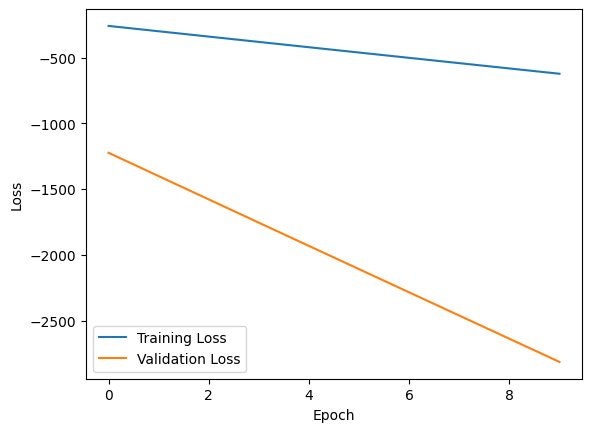

In [88]:

loss, accuracy = model_week7.evaluate(test_dataset)
print(f'loss =( : {loss}')
print(f'accuracy  =) : {accuracy}')

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Model Inference

In this step, you will use the trained model to make predictions on new, unseen data (inference). Here’s an outline of the key points:

1. **Create Test Sample**:
   Create a string to test your modelm the goal here is to give the model Before making predictions, ensure that the new data is preprocessed in the same way as the training data. This includes tokenization, padding, and any other transformations you applied during the data preprocessing step. The data can be single text to see the result of the prediction.

2. **Model Prediction**:
   Use the `predict()` method to feed new samples into the trained model and obtain predictions. The model will output probabilities or predicted class labels based on the type of classification task (binary or multi-class).

3. **Interpreting Predictions**:
   The model will return probabilities for each class.

In [87]:
# test
new_text = "أنا أحب السعودية"
new_text = clean_the_text_week7(new_text)
new_sequence = tokenizer.texts_to_sequences([new_text])
new_padded_sequence = pad_sequences(new_sequence, padding='post', maxlen=100)
prediction = model_week7.predict(new_padded_sequence)
print(f"Predict: {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predict: [[1.]]


# Notebook Question:
- How did you handle text preprocessing? Why did you choose this approach?

- Why did you choose this model design?

- Why did you pick this number of layers or units for the model?

- Why did you select these evaluation methods?

- Does your model show signs of overfitting or underfitting? How do you know?

- What changes could you make to improve the model and fix overfitting or underfitting?

### resource :
1. https://pypi.org/project/Arabic-Stopwords/
2. https://www.nltk.org/
3. https://docs.python.org/3/library/re.html
4. https://pyarabic.readthedocs.io/ar/latest/README.html#features
5. https://docs.python.org/3/library/re.html
6. https://keras.io/api/models/sequential/
7. https://keras.io/api/layers/recurrent_layers/lstm/
8. https://keras.io/api/layers/core_layers/embedding/
9.https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
